In [62]:
import os

import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from hq.config import Config

In [63]:
figure_path = '../tex/figures'
os.makedirs(figure_path, exist_ok=True)

### Compare DR14 to DR16:

In [2]:
dr14 = fits.getdata('/Users/apricewhelan/data/APOGEE_DR14/allStar-l31c.2.fits')
dr16 = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStarLite-r12-l33.fits')

In [3]:
(dr16['LOGG'] > 0).sum() / (dr14['LOGG'] > 0).sum()

2.655712822306616

---

### Statistics for sources that we ran on:

In [7]:
c = Config.from_run_name('dr16')

In [8]:
allstar, allvisit = c.load_alldata()

In [143]:
len(np.unique(dr16['APOGEE_ID'])), len(np.unique(allstar['APOGEE_ID']))

(437485, 232531)

In [144]:
len(np.unique(dr16['APOGEE_ID'])) - len(np.unique(allstar['APOGEE_ID']))

204954

In [146]:
204954 - (dr16['NVISITS'] < 3).sum()

17100

### TEFF-LOGG:

61788 149192


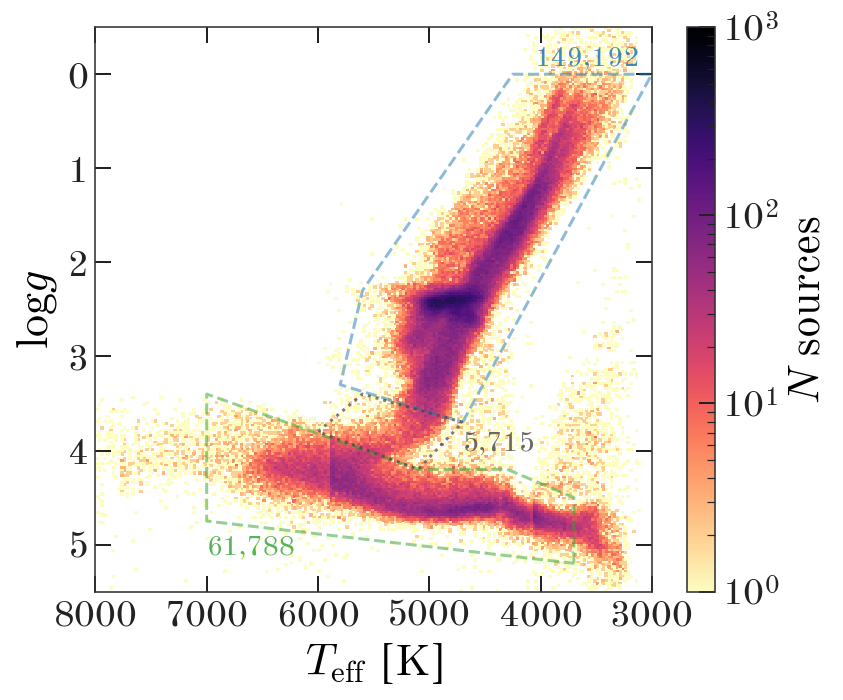

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

xlim = (3000, 8000)
ylim = (-0.5, 5.5)
H, xe, ye = np.histogram2d(
    allstar['TEFF'], allstar['LOGG'], 
    bins=(np.arange(xlim[0], xlim[1]+1e-3, 25),
          np.arange(ylim[0], ylim[1]+1e-3, 0.025)))
im = ax.pcolormesh(xe, ye, H.T, 
                   cmap='magma_r', 
                   norm=mpl.colors.LogNorm(vmin=1, vmax=1e3),
                   rasterized=True)

ax.set_xlim(xlim[::-1])
ax.set_ylim(ylim[::-1])

ax.set_xlabel(fr'$T_{{\rm eff}}$ [{u.Kelvin:latex_inline}]')
ax.set_ylabel(r'$\log g$')

cb = fig.colorbar(im)
cb.set_label('$N$ sources')

rg_nodes = np.array([[4700, 3.7],
                     [3000, 0.],
                     [4250, 0.],
                     [5600, 2.3],
                     [5800, 3.3],
                     [4700, 3.7]])
ax.plot(rg_nodes[:, 0], rg_nodes[:, 1], 
        color='tab:blue', marker='', ls='--', alpha=0.5)

ms_nodes = np.array([[3700, 5.2],
                     [3700, 4.5],
                     [4300, 4.2],
                     [5100, 4.2],
                     [7000, 3.4],
                     [7000, 4.75],
                     [3700, 5.2]])
ax.plot(ms_nodes[:, 0], ms_nodes[:, 1], 
        color='tab:green', marker='', ls='--', alpha=0.5)

sg_nodes = np.array([[4700, 3.7],
                     [5600, 3.4],
                     [6000, 3.8],
                     [5100, 4.2],
                     [4700, 3.7]])
ax.plot(sg_nodes[:, 0], sg_nodes[:, 1], 
        color='#444444', marker='', ls=':', alpha=0.7)

X = np.stack((allstar['TEFF'], allstar['LOGG'])).T
n_ms = mpl.path.Path(ms_nodes).contains_points(X).sum()
n_rg = mpl.path.Path(rg_nodes).contains_points(X).sum()
n_sg = mpl.path.Path(sg_nodes).contains_points(X).sum()

ax.text(7000, 5.1, f'{n_ms:,}', color='tab:green', alpha=0.8, fontsize=14)
ax.text(3100, -0.1, f'{n_rg:,}', color='tab:blue', alpha=0.85, fontsize=14, ha='right')
ax.text(4700, 4, f'{n_sg:,}', color='#444444', alpha=0.8, fontsize=14)

print(n_ms, n_rg)
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'specHR.pdf'), dpi=250)

### Time statistics:

In [9]:
t = at.Table()
for col in ['APOGEE_ID', 'JD', 'VHELIO']:
    t[col] = allvisit[col]
df = t.to_pandas()

In [10]:
g = df.groupby('APOGEE_ID')

In [11]:
nvisits = g['APOGEE_ID'].count()
(nvisits >= 10).sum()

17786

### Nvisits, Baseline:

In [12]:
baseline = g['JD'].apply(np.ptp)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [13]:
np.percentile(baseline, [5, 50, 95])

array([  3.9706 ,  55.8661 , 794.85964])

In [14]:
8 * np.percentile(baseline, 99)

15078.62120000273

In [106]:
nvisits = g['APOGEE_ID'].count()

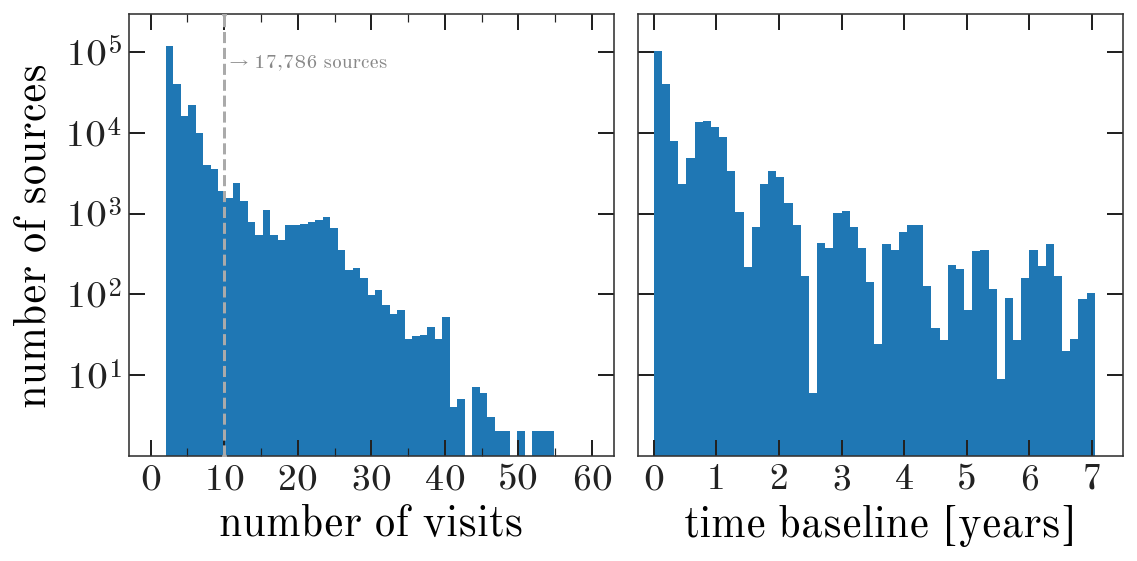

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(8., 4), sharey=True)

ax = axes[0]
ax.hist(nvisits, bins=np.linspace(0, 60, 60), rasterized=True);

ax.axvline(10., zorder=100, color='#aaaaaa', linestyle='--')
n10 = (nvisits >= 10).sum()
ax.text(10, 1e5, f' → {n10:,} sources',
        ha='left', va='top', color='#888888')

ax.xaxis.set_ticks(np.arange(0, 60+1, 10))
ax.xaxis.set_ticks(np.arange(0, 60+1, 5), minor=True)

ax.set_xlabel('number of visits')
ax.set_ylabel('number of sources')

ax = axes[1]
ax.hist(baseline / 365.25, bins=np.linspace(0, 3000/365, 64), rasterized=True);
ax.set_yscale('log')
ax.set_xlabel('time baseline [years]')

ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xlim(-0.25, 7.5)

ax.yaxis.set_ticks(10**np.arange(1, 5+1, 1))
ax.set_ylim(1e0, 3e5)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'visitstats.pdf'), dpi=250)

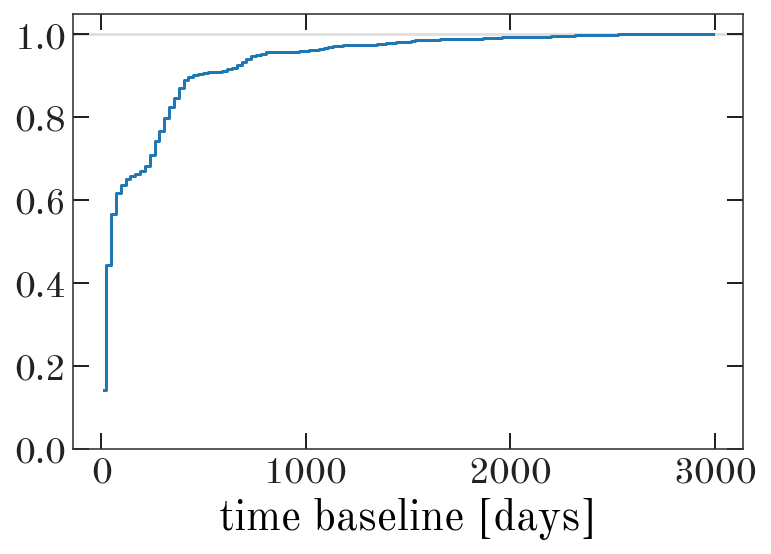

In [11]:
H, xe = np.histogram(baseline, bins=np.linspace(0, 3000, 128))
ctr = 0.5*(xe[:-1]+xe[1:])
plt.plot(ctr, np.cumsum(H) / H.sum(), marker='', drawstyle='steps-mid')
plt.ylim(0, 1.05)
plt.xlabel('time baseline [days]')
plt.axhline(1, zorder=-10, alpha=0.2)

In [157]:
((baseline < 56).sum() / len(baseline),
 (baseline < 365).sum() / len(baseline))

(0.5061217644099066, 0.8364218104252766)

In [161]:
(baseline > 1000).sum()

9743

## RV distribution


In [69]:
from scipy.stats import norm

(1e-06, 0.01)

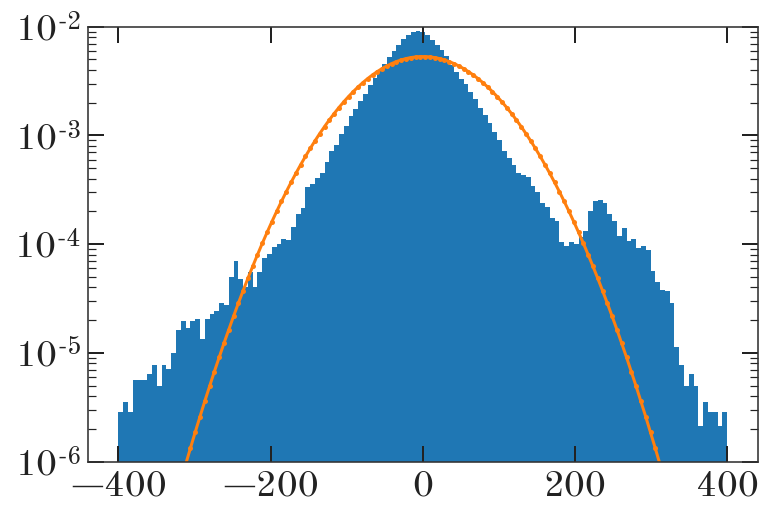

In [80]:
plt.hist(allstar['VHELIO_AVG'], 
         bins=np.linspace(-400, 400, 128), 
         density=True);

grid = np.linspace(-400, 400, 128)
plt.plot(grid, norm.pdf(grid, 0, 75))

plt.yscale('log')
plt.ylim(1e-6, 1e-2)